# loading postgresql dataset

<h3>The Goal</h3>
<br>

<b>the goal here is to assess whehter we can successfully replicate the sentiment analysis capability of a LLM, with various other NLP methods</b>

<br>

We are going to try following methods

<ol>
    <li>Embedding : sentiment analysis with vector embeddings</li>
    <li>TF-IDF : sentiment analysis with traditional TF-IDF method</li>
</ol>

first we will fetch a small framgment (30k entries) of the dataset from the postgresql database for testing, and save them in csv file

<b>While fetching the data from the database, we will need to randomize it on the database itself, so to avoid any pattern which might have appeared in the data creation process

In [1]:
from dotenv import load_dotenv
import os

load_dotenv("utils/.env",override=True)


POSTGRESQL_DATABASE=os.getenv("POSTGRESQL_DATABASE")
POSTGRESQL_USER=os.getenv("POSTGRESQL_USER")
POSTGRESQL_PASSWORD=os.getenv("POSTGRESQL_PASSWORD")
HOST=os.getenv("HOST")

In [2]:
import psycopg2
import pandas as pd

def fetch_email_data(limit=1000, randomness=True):
    # Define your database credentials
    conn = psycopg2.connect(
        dbname=POSTGRESQL_DATABASE,
        user=POSTGRESQL_USER,
        password=POSTGRESQL_PASSWORD,
        host=HOST,
        port="5432"
    )
    
    cur = conn.cursor()
    
    if randomness:
        query = f"""
                SELECT platform, email_id, received_at, sent_at, sent_from, sent_to, 
                    conversation_id, reply_to, subject, full_body, date_extracted
                FROM public.email_data_fields
                ORDER BY RANDOM()
                LIMIT {limit}
                """
    else:
        query = f"""
                SELECT platform, email_id, received_at, sent_at, sent_from, sent_to, 
                    conversation_id, reply_to, subject, full_body, date_extracted
                FROM public.email_data_fields
                LIMIT {limit}
                """
    
    cur.execute(query)
    
    # Fetch results and convert to DataFrame
    columns = [desc[0] for desc in cur.description]
    results = cur.fetchall()
    df = pd.DataFrame(results, columns=columns)
    
    # Close connection
    cur.close()
    conn.close()
    
    return df


In [3]:
df = fetch_email_data(30000)

## load the previous data dump

In [1]:
import pandas as pd
# df.to_csv("dataset/postgresql-dump-30k.csv", index=False)

df = pd.read_csv("dataset/postgresql-dump-30k.csv")

In [2]:
df.head()

,platform,email_id,received_at,sent_at,sent_from,sent_to,conversation_id,reply_to,subject,full_body,date_extracted
0,NaN,5778f63d2a7a1fc12ed3225e99574068,2000-11-10 02:50:00,2000-11-10 02:50:00,ebass@enron.com,ebass@enron.com,NaN,NaN,Commissioner.COM Transaction Request,This in an automated e-mail sent out from the ...,2025-02-22
1,NaN,58cd5d1b9b84ad4ae5317a2c9de5fe73,2000-09-15 06:44:00,2000-09-15 06:44:00,shona.wilson@enron.com,"ted.murphy@enron.com, sally.beck@enron.com",NaN,NaN,updated budget for doorstep,There was an incorrect formula in the previous...,2025-02-22
2,NaN,c773eee1e97da6650453f02037f47511,2000-10-23 10:11:00,2000-10-23 10:11:00,eric.bass@enron.com,lwbthemarine@bigplanet.com,NaN,NaN,Re: election night,That sounds like a good idea. I guess you wil...,2025-02-22
3,NaN,059c294f34b1cb201ae60e5750bcff05,2001-09-26 08:42:04,2001-09-26 08:42:04,eric.bass@enron.com,patrick.ryder@enron.com,NaN,NaN,(No Subject),http://www.dailytexanonline.com/vnews/display....,2025-02-22
4,NaN,2c8cb45b0a159d731078eb6f04ac8234,2000-09-05 01:45:00,2000-09-05 01:45:00,john.sorrells@enron.com,"donna.lowry@enron.com, richard.lauer@enron.com",NaN,NaN,Reporting,"Donna and RIchard,\n\nMore information for you...",2025-02-22


# text preprocessing

first we will get the the character length for each mail to check if one of the mails is beyond say 10000 characters. Because in such cases it is more likely to be a legal document etc.

In [3]:
import numpy as np

char_len_list = []

for n, mail in enumerate(df['full_body']):

    if not pd.isna(mail):
        char_len_list.append(len(mail))

char_len_list= np.array(char_len_list)

# data visualization

In [4]:
print("### stats for mail body")

print(f"mean : {int(char_len_list.mean())}, median : {int(np.median(char_len_list))}, min : {min(char_len_list)}, max : {max(char_len_list)}")

### stats for mail body
mean : 266, median : 185, min : 1, max : 1000


<h3>Observations :</h3>
<br>
All the mails are under 1k charater lengths. so there are no such outliers. at least in our sample

In [5]:
import matplotlib.pyplot as plt

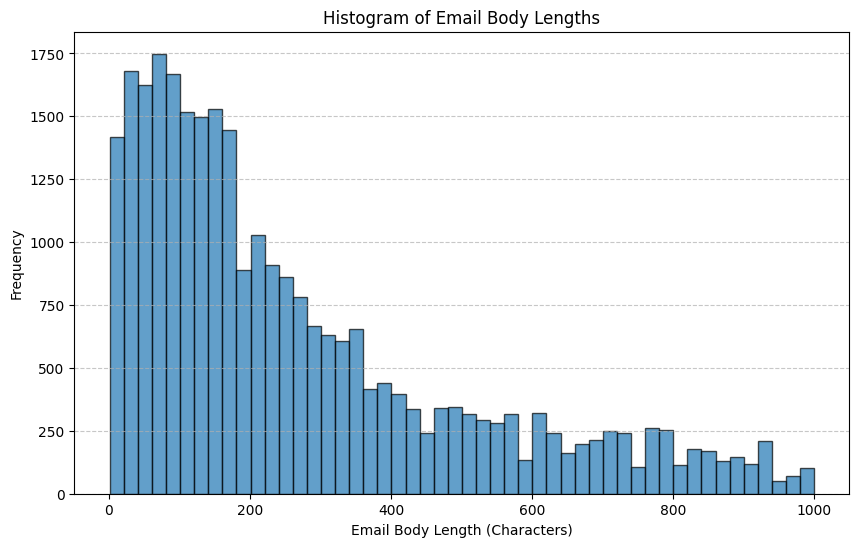

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(char_len_list, bins=50, edgecolor='black', alpha=0.7)

plt.xlabel("Email Body Length (Characters)")
plt.ylabel("Frequency")
plt.title("Histogram of Email Body Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

<h3>Observations :</h3>
<br>
most of the emails are under 500 characters or less.

# Unlabelled data : Labeling the data with LLM

the present dataset does not have the any labeling. So to resolve this issue, we can use LLMs to label the mails in following three classes : Positive, Negative & Neutral

In [7]:
from dotenv import load_dotenv
import os
from groq import Groq

load_dotenv("utils/.env",override=True)  # Load .env file

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [8]:
class groq_model:
    def __init__(self, model="gemma2-9b-it"):
        self.client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        self.model_name = model

    def get_response(self, query):
        chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": query,
                    }
                ],
                model=self.model_name,
                
            )
        
        return chat_completion.choices[0].message.content

## prepare a small dataset

In [9]:
import json
from time import sleep
import re
def extract_json_from_text(text):
    pattern = r'```json\s*(\{[\s\S]*?\})\s*```'
    match = re.search(pattern, text, re.DOTALL)
    
    if match:
        json_str = match.group(1)
    else:
        # Fallback: try to extract any JSON object from the text
        match = re.search(r'(\{[\s\S]*\})', text)
        if match:
            json_str = match.group(1)
        else:
            return None

    try:
        data = json.loads(json_str)
        # Optionally verify the expected structure:
        if "response" in data and isinstance(data["response"], list):
            return data
        else:
            print("JSON does not match the expected format (missing 'response' key or it is not a list).")
            return None
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        return None

<h4>We will be first using the following prompt to let the know the LLM what is its task and how it should return the classification result</h4>


In [10]:
with open("utils/prompts/detect-classification.txt", "r") as f:
    prompt = f.read()

with open("utils/sentiments.json", "r") as f:
    sentiment_classes = json.load(f)

In [11]:
sentiment_classes

['Positive', 'Negative', 'Neutral']

In [12]:
sentiments_str = ""

for i, s in enumerate(sentiment_classes):
    sentiments_str+=f"{i+1}. {s}\n"
sentiments_str

'1. Positive\n2. Negative\n3. Neutral\n'

In [13]:
df.columns

Index(['platform', 'email_id', 'received_at', 'sent_at', 'sent_from',
       'sent_to', 'conversation_id', 'reply_to', 'subject', 'full_body',
       'date_extracted'],
      dtype='object')

<h4>we will now run the LLM with our sampled data and get it labelled & convert it into a csv file

In [ ]:
# small_data = []

with open("output/output.json", "r") as f:
    small_data = json.load(f)

lag= 4100

sm_db_size = 450+lag
done_num = 0+lag
idx = 0+lag

sleep_time = 3

# model = groq_model()
model = groq_model(model="llama-3.1-8b-instant")
# model = groq_model(model="llama3-8b-8192")
# model = groq_model(model="llama-3.3-70b-versatile")




while done_num<sm_db_size:   
    
    mail = df['full_body'][idx]

    if pd.isna(mail):
        idx+=1
        continue
        
    # if len(mail)>large_char_len:
    #     idx+=1
    #     continue

    try:
        # identifying the values
        mail_date = df['sent_at'][idx]
        mail_from = df['sent_from'][idx]
        mail_to = df['sent_to'][idx]
        mail_subject = df['subject'][idx]

        query = prompt.replace("$#emailbody#$", mail).replace("$#sentiment-categories#$", sentiments_str)
        response = model.get_response(query)

        # print(response)

        result_class = extract_json_from_text(response)['response']


        highest_category = max(result_class, key=lambda x: x["probability"])

        mail_dict = {"body":mail, "class":highest_category["category_name"], "probability":highest_category["probability"], "Date":mail_date, 
                        "From":mail_from,
                        "To":mail_to,
                        "Subject":mail_subject}

        small_data.append(mail_dict)
    
    except:
        print("Exception occured skipping this", idx)
        continue

    idx+=1
    done_num+=1

    print(f"done : {idx}")

    with open("output/output.json", "w") as f:
        json.dump(small_data, f)

    sleep(sleep_time)



In [ ]:
len(small_data)

In [16]:
import json
# with open("output/output.json", "w") as f:
#     json.dump(small_data, f)

with open("output/output.json", "r") as f:
    small_data = json.load(f)


In [17]:
len(small_data)

2191

In [18]:
import pandas as pd

In [21]:
# new_df = pd.DataFrame(small_data)
# new_df.to_csv("output/output.csv", index=False)

new_df = pd.read_csv("output/output.csv")
len(new_df)

2191

In [22]:
new_df.columns

Index(['body', 'class', 'probability', 'Date', 'From', 'To', 'Subject'], dtype='object')

In [23]:
import matplotlib.pyplot as plt

[]

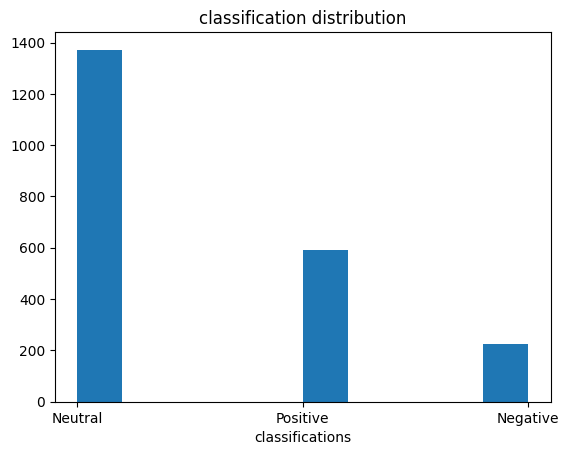

In [24]:
plt.hist(new_df['class'])

plt.xlabel("classifications")
plt.title("classification distribution")
plt.plot()

<h3>Observations :</h3>
<ul>
    <li>the Negative sentiments are very under-represented in our dataset, which is not helpful.
    <li>similarly the positive sentiments are also under represented, though they are double that of negative classes

# dataset preperation

<h3>Droping the other classes</h3>
<br>
#### to resolve the issue of unbalanced data, we are just going to drop all other data points for Positive and Neutral classification and bring them to the level of Negatives

#### data preprocessing

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
new_df['class'].value_counts()

class
Neutral     1372
Positive     593
Negative     226
Name: count, dtype: int64

In [27]:
new_df['probability'] = new_df['probability'].astype(np.int16)

[]

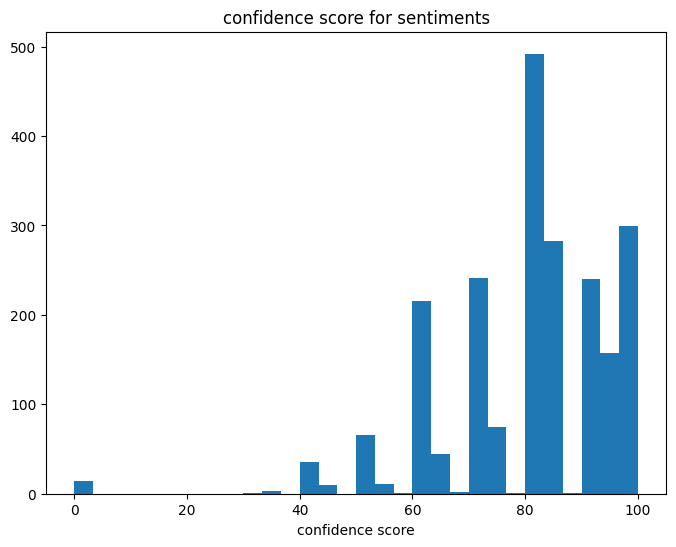

In [28]:
plt.figure(figsize=(8,6))
plt.hist(new_df['probability'], bins=30)
plt.xlabel("confidence score")
plt.title("confidence score for sentiments")
plt.plot()

<h3>Observations :</h3>
<br>
We can see that there are some observations that have below 50% confidence. we are also going to filter them out, so that the model does not get confused about the classification

In [29]:
len(new_df)

2191

In [30]:
df_filtered = new_df[new_df['probability']>50]
len(df_filtered)

2063

[]

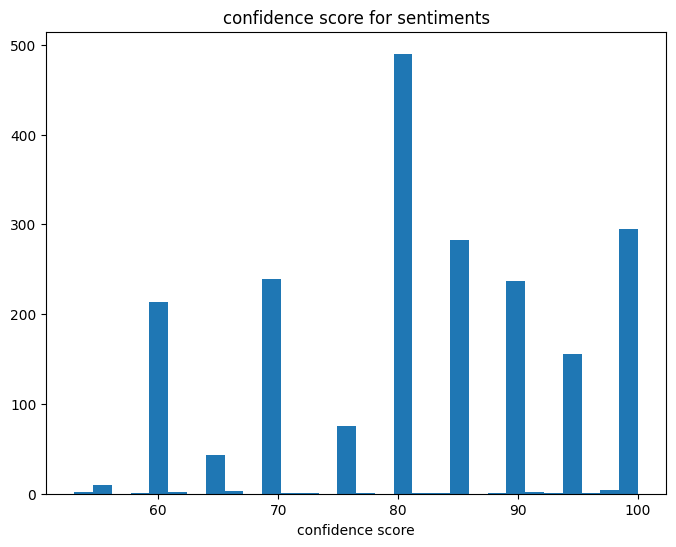

In [31]:
plt.figure(figsize=(8,6))
plt.hist(df_filtered['probability'], bins=30)
plt.xlabel("confidence score")
plt.title("confidence score for sentiments")
plt.plot()

<h3>Observations :</h3>
<br>
Now all the sentiments have over 50% of confidence

In [32]:
df_filtered['class'].value_counts()


class
Neutral     1304
Positive     553
Negative     206
Name: count, dtype: int64

In [33]:
negative_class_len = len(df_filtered[df_filtered['class']=="Negative"])
negative_class_len

206

In [124]:
from sklearn.utils import resample

# Separate classes
df_negative = df_filtered[df_filtered['class'] == 'Negative']
df_positive = df_filtered[df_filtered['class'] == 'Positive']
df_neutral = df_filtered[df_filtered['class'] == 'Neutral']

negative_class_len = len(df_negative)

# Downsample majority classes
df_positive_resampled = resample(df_positive, replace=False, n_samples=negative_class_len, random_state=42)
df_neutral_resampled = resample(df_neutral, replace=False, n_samples=negative_class_len, random_state=42)

# Combine all classes into a new balanced dataset
df_balanced = pd.concat([df_negative, df_positive_resampled, df_neutral_resampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution
df_balanced['class'].value_counts()


class
Negative    206
Neutral     206
Positive    206
Name: count, dtype: int64

#### double the negatives

<h3>Observations :</h3>
<br>
After doubling the negatives it did not improve the accuracy

In [104]:
# from sklearn.utils import resample

# # Separate classes
# df_negative = df_filtered[df_filtered['class'] == 'Negative']
# df_negative = pd.concat([df_negative] * 2, ignore_index=True)

# negative_class_len = len(df_negative)

# df_positive = df_filtered[df_filtered['class'] == 'Positive']
# df_neutral = df_filtered[df_filtered['class'] == 'Neutral']

# # Downsample majority classes
# df_positive_resampled = resample(df_positive, replace=False, n_samples=negative_class_len, random_state=42)
# df_neutral_resampled = resample(df_neutral, replace=False, n_samples=negative_class_len, random_state=42)

# # Combine all classes into a new balanced dataset
# df_balanced = pd.concat([df_negative, df_positive_resampled, df_neutral_resampled])

# # Shuffle the dataset
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # Check class distribution
# df_balanced['class'].value_counts()


class
Neutral     124
Negative    124
Positive    124
Name: count, dtype: int64

In [35]:
df_balanced.head()

,body,class,probability,Date,From,To,Subject
0,did you buy any enron in the 60s?,Negative,90,2000-12-06 07:03:00,eric.bass@enron.com,lwbthemarine@bigplanet.com,(No Subject)
1,"Gary,\n\nWhat is the market for IAH Jan-Mar HD...",Neutral,85,2000-12-06 09:32:00,eric.bass@enron.com,gary.taylor@enron.com,JAN-MAR Degree Day Swaps
2,he hates the farmers down at the pulse machine...,Negative,95,2001-02-07 02:06:00,eric.bass@enron.com,david.baumbach@enron.com,Re: The Next HEISMAN winner for the University...
3,"Hey,\n\nHow are things going with you guys? W...",Positive,70,2001-12-11 08:09:26,eric.bass@enron.com,daphneco64@alltel.net,Mr. Hamilton
4,you might want to save yourself the agony of h...,Negative,80,2000-02-28 04:27:00,eric.bass@enron.com,shanna.husser@enron.com,Re:


In [36]:
len(df_balanced)

618

In [37]:
len(df_balanced)

618

# embedding based classification

#### data processing

We will use "all-MiniLM-L6-v2" model to convert the text into embeddings. For model training

In [38]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
emdeddingModel = SentenceTransformer("all-MiniLM-L6-v2")

/home/heramb96/miniconda3/envs/glynac/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [125]:
df_balanced = pd.get_dummies(df_balanced, columns=['class'], dtype=int)

In [126]:
df_balanced.head()

,body,probability,Date,From,To,Subject,class_Negative,class_Neutral,class_Positive
0,did you buy any enron in the 60s?,90,2000-12-06 07:03:00,eric.bass@enron.com,lwbthemarine@bigplanet.com,(No Subject),1,0,0
1,"Gary,\n\nWhat is the market for IAH Jan-Mar HD...",85,2000-12-06 09:32:00,eric.bass@enron.com,gary.taylor@enron.com,JAN-MAR Degree Day Swaps,0,1,0
2,he hates the farmers down at the pulse machine...,95,2001-02-07 02:06:00,eric.bass@enron.com,david.baumbach@enron.com,Re: The Next HEISMAN winner for the University...,1,0,0
3,"Hey,\n\nHow are things going with you guys? W...",70,2001-12-11 08:09:26,eric.bass@enron.com,daphneco64@alltel.net,Mr. Hamilton,0,0,1
4,you might want to save yourself the agony of h...,80,2000-02-28 04:27:00,eric.bass@enron.com,shanna.husser@enron.com,Re:,1,0,0


In [127]:
X = df_balanced['body']
y = df_balanced[["class_Negative","class_Neutral", "class_Positive"]]
y = np.argmax(y.values, axis=1)

In [128]:
X = emdeddingModel.encode(X)
X.shape

(618, 384)

## model training

We will try both Deep learning and Machine learning methods to check for best model

First we will try with a simple fully connected Neural Network

## Neural Network

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# y_train.value_counts()

In [130]:
X_train.shape

(494, 384)

In [131]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# class TextClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3, activation_fn=nn.ReLU):
#         super(TextClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.actFunc = activation_fn()
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.actFunc2 = activation_fn()
#         self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.actFunc(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.actFunc2(x)
#         x = self.fc3(x)
#         return x

# # Model parameters
# input_dim = X_train.shape[1]  # Sentence embedding dimension
# hidden_dim = 256
# output_dim = 3  # Three classes

# model = TextClassifier(input_dim, hidden_dim, output_dim, dropout_rate=0.5, activation_fn=nn.GELU)


In [132]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3, activation_fn=nn.ReLU):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.actFunc = activation_fn()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.actFunc2 = activation_fn()
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim * 2)
        self.actFunc3 = activation_fn()
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim // 2)
        self.actFunc4 = activation_fn()
        self.fc5 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actFunc(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.actFunc2(x)
        x = self.fc3(x)
        x = self.actFunc3(x)
        x = self.fc4(x)
        x = self.actFunc4(x)
        x = self.fc5(x)
        return x





In [ ]:
# import torch
# import torch.nn as nn

# class TextClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3, activation_fn=nn.ReLU):
#         super(TextClassifier, self).__init__()
        
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
#         self.actFunc1 = activation_fn()
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.bn2 = nn.BatchNorm1d(hidden_dim // 2)  
#         self.actFunc2 = activation_fn()
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_dim // 2, output_dim)  # Final output layer

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)  # Apply BatchNorm
#         x = self.actFunc1(x)
#         x = self.dropout1(x)
        
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.actFunc2(x)
#         x = self.dropout2(x)

#         x = self.fc3(x)  # No activation here (raw logits for CrossEntropyLoss)
#         return x


In [133]:
# Model parameters
input_dim = X_train.shape[1]  # Sentence embedding dimension
hidden_dim = int(input_dim*1.5)
output_dim = 3  # Three classes

# model = TextClassifier(input_dim, hidden_dim, output_dim, dropout_rate=0.3)
model = TextClassifier(input_dim, hidden_dim, output_dim, dropout_rate=0.3, activation_fn=nn.GELU)

In [134]:
input_dim, hidden_dim

(384, 576)

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [136]:
num_epochs = 500  # Increase epochs for better learning
total_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # loss = criterion(outputs, torch.max(y_batch, 1)[1])  # Convert one-hot to class indices

        loss = criterion(outputs, y_batch.to(torch.long))  # Convert one-hot to class indices

        

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    total_loss_list.append(avg_loss)  # Store average loss for this epoch
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.0986
Epoch 2, Loss: 1.0959
Epoch 3, Loss: 1.0866
Epoch 4, Loss: 1.0421
Epoch 5, Loss: 0.9007
Epoch 6, Loss: 0.7895
Epoch 7, Loss: 0.7341
Epoch 8, Loss: 0.6655
Epoch 9, Loss: 0.6211
Epoch 10, Loss: 0.5838
Epoch 11, Loss: 0.5270
Epoch 12, Loss: 0.4748
Epoch 13, Loss: 0.4636
Epoch 14, Loss: 0.4315
Epoch 15, Loss: 0.4172
Epoch 16, Loss: 0.3878
Epoch 17, Loss: 0.3847
Epoch 18, Loss: 0.3433
Epoch 19, Loss: 0.3226
Epoch 20, Loss: 0.2923
Epoch 21, Loss: 0.2605
Epoch 22, Loss: 0.2403
Epoch 23, Loss: 0.2267
Epoch 24, Loss: 0.1995
Epoch 25, Loss: 0.1955
Epoch 26, Loss: 0.1706
Epoch 27, Loss: 0.1637
Epoch 28, Loss: 0.1548
Epoch 29, Loss: 0.1404
Epoch 30, Loss: 0.1589
Epoch 31, Loss: 0.1559
Epoch 32, Loss: 0.1264
Epoch 33, Loss: 0.1303
Epoch 34, Loss: 0.1140
Epoch 35, Loss: 0.1010
Epoch 36, Loss: 0.1254
Epoch 37, Loss: 0.1252
Epoch 38, Loss: 0.0977
Epoch 39, Loss: 0.0964
Epoch 40, Loss: 0.1041
Epoch 41, Loss: 0.1021
Epoch 42, Loss: 0.0845
Epoch 43, Loss: 0.0954
Epoch 44, Loss: 0.07

In [ ]:
# model.eval()
# correct, total = 0, 0

# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = model(X_batch)
#         predicted = torch.argmax(outputs, axis=1)
#         actual = torch.argmax(y_batch, axis=1)
#         correct += (predicted == actual).sum().item()
#         total += y_batch.size(0)

# accuracy = correct / total
# print(f"Test Accuracy: {accuracy:.4f}")


In [139]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)  # Get raw logits
        predicted = torch.argmax(outputs, dim=1)  # Get predicted class index

        # No need for argmax on y_batch since it's already class indices
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7258


In [146]:
# saving the model

onnx_model_path = "model/embedding-NN-model.onnx"

dummy_input = torch.randn(1, input_dim)

torch.onnx.export(model,
                  dummy_input,
                  onnx_model_path,
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=11)

print(f"ONNX model has been saved to {onnx_model_path}")

ONNX model has been saved to model/embedding-NN-model.onnx


<h3>Observations :</h3>
<br>
We got around 65-71 % accuracy with the neural network model

In [66]:
len(total_loss_list)

500

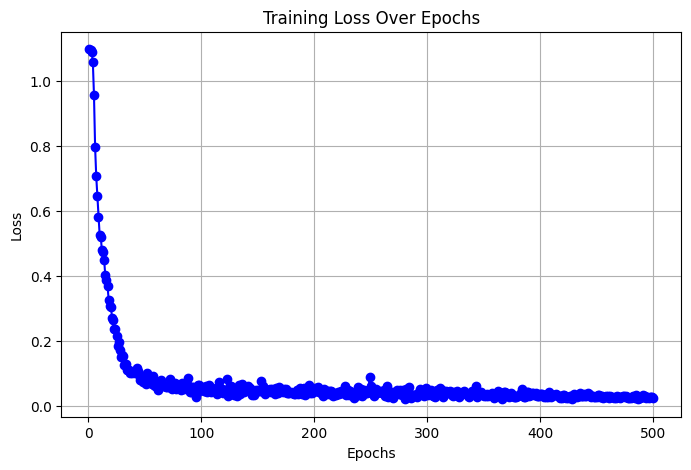

In [67]:
last_epochs = num_epochs

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs-(num_epochs-last_epochs) + 1), total_loss_list[-last_epochs:], marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()


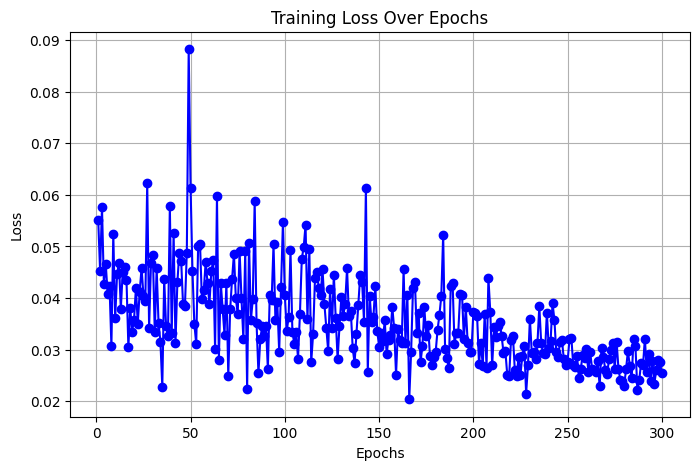

In [68]:
last_epochs = 300

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs-(num_epochs-last_epochs) + 1), total_loss_list[-last_epochs:], marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()


## ML models

In [69]:
from sklearn.metrics import confusion_matrix, classification_report

In [70]:
X = df_balanced['body']
y = df_balanced[["class_Negative","class_Neutral", "class_Positive"]]
y = np.argmax(y.values, axis=1)

In [71]:
X = emdeddingModel.encode(X)
X.shape

(618, 384)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Train a logistic regression model
model = LogisticRegression(multi_class='ovr', solver='liblinear')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.65


/home/heramb96/miniconda3/envs/glynac/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [74]:
confusion_matrix(y_test, y_pred)


array([[30,  5,  2],
       [14, 14,  8],
       [ 5,  9, 37]])

In [75]:
precision = precision_score(y_test, y_pred, average=None)  # Per-class precision
recall = recall_score(y_test, y_pred, average=None) 

In [76]:
precision

array([0.6122449 , 0.5       , 0.78723404])

In [77]:
recall

array([0.81081081, 0.38888889, 0.7254902 ])

<h3>Observations :</h3>
<br>
we did not get good accuracy score with logistic regression model

In [78]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")


Random Forest Accuracy: 0.67


<h3>Observations :</h3>
<br>
The results we got with Random Forest classifier are good and on par with the NN model

#  TF-IDF based training

Now we will use the traditional NLP method for sentiment analysis

In [79]:

import string
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package wordnet to /home/heramb96/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/heramb96/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/heramb96/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/heramb96/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/heramb96/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [80]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Remove newlines
    text = re.sub(r'\n', '', text)
    # Remove alphanumeric words (words containing digits)
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove remaining non-alphabetic characters (except spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Normalize repeated characters (e.g., "soooo" -> "so")
    text = re.sub(r'(.)\1+', r'\1\1', text)
  
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Stem words using LancasterStemmer
    stemmer = LancasterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back into a single string
    text = ' '.join(words)
    
    return text

In [81]:
from sklearn.utils import resample

# Separate classes
df_negative = df_filtered[df_filtered['class'] == 'Negative']
df_positive = df_filtered[df_filtered['class'] == 'Positive']
df_neutral = df_filtered[df_filtered['class'] == 'Neutral']

negative_class_len = len(df_negative)

# Downsample majority classes
df_positive_resampled = resample(df_positive, replace=False, n_samples=negative_class_len, random_state=42)
df_neutral_resampled = resample(df_neutral, replace=False, n_samples=negative_class_len, random_state=42)

# Combine all classes into a new balanced dataset
df_balanced = pd.concat([df_negative, df_positive_resampled, df_neutral_resampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution
df_balanced['class'].value_counts()


class
Negative    206
Neutral     206
Positive    206
Name: count, dtype: int64

In [82]:
df_balanced = pd.get_dummies(df_balanced, columns=['class'], dtype=int)

In [96]:
X = df_balanced['body'].apply(clean_text)
y = df_balanced[["class_Negative","class_Neutral", "class_Positive"]]

In [84]:
X[0]

'buy enron'

In [85]:
from sklearn.model_selection import train_test_split

In [97]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(X)
X = X.toarray()

In [98]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Neural Network

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [99]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [90]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3, activation_fn=nn.ReLU):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.actFunc = activation_fn()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.actFunc2 = activation_fn()
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim * 2)
        self.actFunc3 = activation_fn()
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim // 2)
        self.actFunc4 = activation_fn()
        self.fc5 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actFunc(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.actFunc2(x)
        x = self.fc3(x)
        x = self.actFunc3(x)
        x = self.fc4(x)
        x = self.actFunc4(x)
        x = self.fc5(x)
        return x





In [100]:
# Model parameters
input_dim = X_train.shape[1]  # Sentence embedding dimension
hidden_dim = int(input_dim/2)
output_dim = 3  # Three classes

# model = TextClassifier(input_dim, hidden_dim, output_dim, dropout_rate=0.3)
model = TextClassifier(input_dim, hidden_dim, output_dim, dropout_rate=0.3, activation_fn=nn.GELU)

In [101]:
input_dim, hidden_dim

(2000, 1000)

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [103]:
num_epochs = 600  # Increase epochs for better learning
total_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])  # Convert one-hot to class indices

        # loss = criterion(outputs, y_batch.to(torch.long))  # Convert one-hot to class indices

        

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    total_loss_list.append(avg_loss)  # Store average loss for this epoch
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.0915
Epoch 2, Loss: 0.6302
Epoch 3, Loss: 0.2490
Epoch 4, Loss: 0.1161
Epoch 5, Loss: 0.1069
Epoch 6, Loss: 0.0922
Epoch 7, Loss: 0.0839
Epoch 8, Loss: 0.0901
Epoch 9, Loss: 0.0724
Epoch 10, Loss: 0.0994
Epoch 11, Loss: 0.0944
Epoch 12, Loss: 0.0786
Epoch 13, Loss: 0.0671
Epoch 14, Loss: 0.0650
Epoch 15, Loss: 0.0694
Epoch 16, Loss: 0.0628
Epoch 17, Loss: 0.0691
Epoch 18, Loss: 0.0780
Epoch 19, Loss: 0.0672
Epoch 20, Loss: 0.1041
Epoch 21, Loss: 0.2241
Epoch 22, Loss: 0.2524
Epoch 23, Loss: 0.3479
Epoch 24, Loss: 0.2356
Epoch 25, Loss: 0.1180
Epoch 26, Loss: 0.1027
Epoch 27, Loss: 0.0650
Epoch 28, Loss: 0.0663
Epoch 29, Loss: 0.0563
Epoch 30, Loss: 0.0551
Epoch 31, Loss: 0.0537
Epoch 32, Loss: 0.0556
Epoch 33, Loss: 0.0524
Epoch 34, Loss: 0.0557
Epoch 35, Loss: 0.0539
Epoch 36, Loss: 0.0557
Epoch 37, Loss: 0.0517
Epoch 38, Loss: 0.0517
Epoch 39, Loss: 0.0556
Epoch 40, Loss: 0.0511
Epoch 41, Loss: 0.0555
Epoch 42, Loss: 0.0462
Epoch 43, Loss: 0.0501
Epoch 44, Loss: 0.04

In [104]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = torch.argmax(outputs, axis=1)
        actual = torch.argmax(y_batch, axis=1)
        correct += (predicted == actual).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.5484


<h3>Observations :</h3>
<br>
we got worse results with TF-IDF method than the embedding method, with the NN method lets check if ML models perform better than this

## ML models

In [106]:
from sklearn.metrics import confusion_matrix, classification_report

In [110]:
X = df_balanced['body']
y = df_balanced[["class_Negative","class_Neutral", "class_Positive"]]
y = np.argmax(y.values, axis=1)

In [111]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(X)
X = X.toarray()

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Train a logistic regression model
model = LogisticRegression(multi_class='ovr', solver='liblinear')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.65


/home/heramb96/miniconda3/envs/glynac/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [116]:
confusion_matrix(y_test, y_pred)

array([[30,  3,  4],
       [ 7, 22,  7],
       [12, 11, 28]])

In [117]:
precision = precision_score(y_test, y_pred, average=None)  # Per-class precision
recall = recall_score(y_test, y_pred, average=None) 

In [118]:
precision

array([0.6122449 , 0.61111111, 0.71794872])

In [119]:
recall

array([0.81081081, 0.61111111, 0.54901961])

<h3>Observations :</h3>
<br>

With Linear regression model we got 65% accuracy with okay other results

In [120]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")


Random Forest Accuracy: 0.56


In [70]:
y_test[:10]

array([1, 0, 1, 2, 1, 0, 2, 2, 1, 0])

<h3>Observations :</h3>
<br>
with random forest classifier we got bad results

# Final Verdict

<b>Vector Embedding Results</b>

Neural Network : 71%

ML Models : 65-67 %

<br>
<b>TF-IDF results</b>

Neural Network : 56% 

ML models : 56-65 %




<h2>Observations :</h2>
<ul>
    <li>Vector Embedding based sentiment analysis works better than the TF-IDF method, yielding better accuracy
    <li>Because the dataset is limited, there is a possibility that if the dataset size is increased then the model would be better able to grasp the sentiments more accurately
    <li>Overall, LLMs are much more suited for muli-class sentiment classification, as they can understand nuiances present in the mail, which embedding or traditional NLP methods may ignore right away
    

</ul>